## Step 4: post-processing the clustering algorithm results

The output geotiff from step 3 will likely have noise and small artefacts that we need to remove before the classified data is actually useful. THis notebook does the following:

- uses opening and closing functions to remove small patches of pixels below a threshold
- uses a median filter to further filter out noise and artefacts
- combines the opening, closing and median filters
- create a new raster from the post-processed classified image
- performs a polygonisation operation to extract the shapes and values from the raster and output a vector geodataframe
- save out the geodataframe as a geojson multipolygon
    - this can be changed to a shapefile or written to postGIS as required


##### These post-processing steps are examples only. Before this goes into production it is important to find the right balance of removing noise without removing important data. This is a demo to show HOW these steps can be done but this is not validated or tested yet.

In [1]:
%pip install scikit-image -q
%pip install --upgrade hvplot holoviews panel jupyter_bokeh bokeh -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
from io import StringIO
from gis_utils.dataframe import get_bbox_from_geodf
import pandas as pd
import geopandas as gpd
import rioxarray
import rasterio.features
import xarray as xr
from skimage.morphology import opening, square, disk, closing
from skimage import filters
import matplotlib.pyplot as plt
import shapely

import holoviews as hv
import hvplot.pandas
hv.extension('bokeh')

import or use this geojson to mask out the area outside the property

In [3]:
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}

req = geojson
geojson_data = req['body']

gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))
gdf.to_crs(epsg=3857, inplace=True)

bbox = get_bbox_from_geodf(geojson_data)

In [4]:
input_dir = "/workspace/notebooks/sandbox/stratification/showcase/data/03-classification"
output_dir = "/workspace/notebooks/sandbox/stratification/showcase/data/04-post_processing"

input_img = rioxarray.open_rasterio(os.path.join(input_dir, "kmeans_draft.tiff"))


The sk-image functions need the data to have the x and y dimensions first, so transpose the imported raster from (`band`,`y`,`x`) to (`y`,`x`,`band`). Yes, y comes before x in this case, its note a typo

In [5]:
input_img_T = input_img.transpose('y', 'x', 'band')
input_img_T =  input_img_T.squeeze()

Perform the sk-image filtering steps. This notebook uses `opening`, `closing` and `median` filtering. Change the `disk_size` to alter the minimum size of the filters. The larger the `disk_size` the more data will be filtered out.

In [6]:
disk_size = 2

cleaned_opening = opening(input_img_T, square(disk_size))

cleaned_closing = closing(input_img_T, square(disk_size))

median_filter = filters.median(input_img_T, disk(disk_size))

median_closing = filters.median(cleaned_closing, disk(disk_size))

median_opening = filters.median(cleaned_opening, disk(disk_size))

opening_closing = closing(opening(input_img_T, square(disk_size)), square(disk_size))

median_opening_closing = filters.median(closing(median_opening, disk(disk_size)))

plot the results to compare

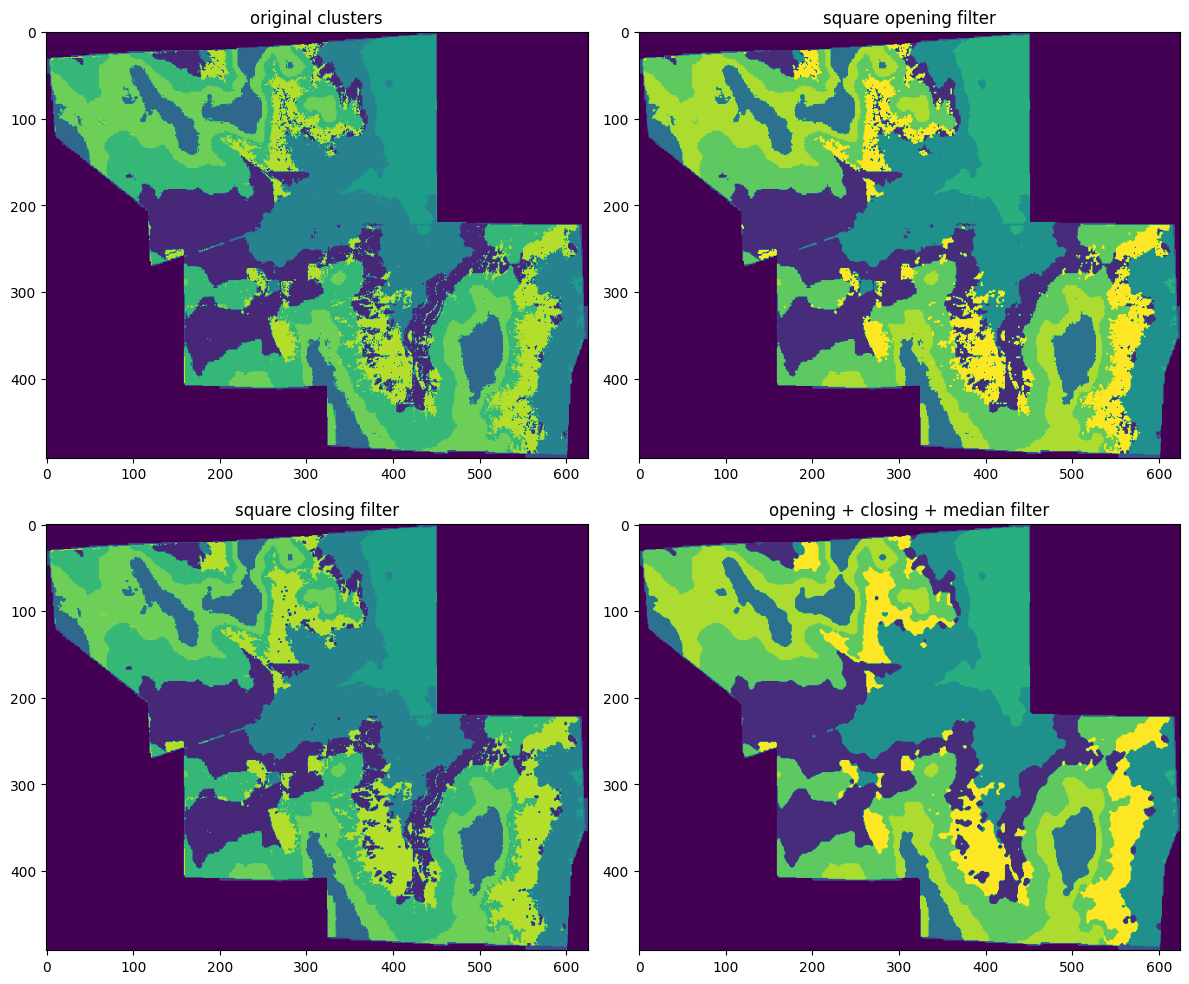

In [7]:
n_rows = 2
n_cols=2

# display results
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*6, n_rows*5))

ax[0,0].imshow(input_img_T, cmap='viridis')
ax[0,0].set_title(r'original clusters')

ax[0,1].imshow(cleaned_opening, cmap='viridis')
ax[0,1].set_title(r'square opening filter')

ax[1,0].imshow(cleaned_closing, cmap='viridis')
ax[1,0].set_title(r'square closing filter')


ax[1,1].imshow(median_opening_closing, cmap='viridis')
ax[1,1].set_title(r'opening + closing + median filter')


fig.tight_layout()
plt.show()

Same as in the third notebook, the results of these filters are standard data arrays, and so do not have any spatial information. We do the same steps that we did to create a spatially aware raster in the previous notebook. Create a new data array, populate it with the results of the filtering step, then write all of the spatial data to the new raster using metadata pulled from the input geotiff (the raw classification results geotiff).

In [8]:
processed_img = xr.DataArray(
    median_opening_closing, 
    coords={
        'y': input_img.coords['y'],
        'x': input_img.coords['x']
    },
    dims=['y', 'x']
)

In [9]:
processed_img.rio.write_crs(input_img.rio.crs, inplace=True)
processed_img.rio.write_transform(input_img.rio.transform(), inplace=True)
processed_img.rio.write_coordinate_system(inplace=True)

processed_img.rio.update_attrs(input_img.attrs, inplace=True)
processed_img.rio.update_encoding(input_img.encoding, inplace=True)
processed_img.rio.write_nodata(-9999, inplace=True)

<xarray.DataArray (y: 492, x: 625)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * y            (y) float64 4kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
  * x            (x) float64 5kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0

##### Don't forget to mask the raster before saving it out

In [10]:
processed_img = processed_img.rio.clip(gdf.geometry.values, drop=False, invert=False)
processed_img.rio.to_raster(os.path.join(output_dir, "kmeans_draft_postprocessed.tiff"))

This 'test' geotiff is where we get the spatial metadata used later on to create a new geotiff with the post-processed results

In [11]:
test_rast = rioxarray.open_rasterio(os.path.join(output_dir, "kmeans_draft_postprocessed.tiff"))

Extract the features from the raster so that we can convert them to polygons:

In [12]:
shapes = rasterio.features.shapes(test_rast.values, mask=test_rast.values != -9999, transform=test_rast.rio.transform(), connectivity=4)
pol = list(shapes)
geom = [shapely.geometry.shape(i[0]) for i in pol]
geom = gpd.GeoSeries(geom, crs=test_rast.rio.crs)

Also extract the values (the classes from the classifier) so that the polygons have data attached to them telling us what class they represent

In [13]:
values = [i[1] for i in pol]
values = pd.Series(values)

Append the polygons and the values together to create a geodataframe:

In [14]:
result = gpd.GeoDataFrame({'value': values, 'geometry': geom})

Save the geodataframe out as a geojson (or shapefile, or write to a postGIS DB)

In [15]:
result.to_file(os.path.join(output_dir, "kmeans_draft_postprocessed.geojson"),  driver="GeoJSON")

In [16]:
test_rast

<xarray.DataArray (band: 1, y: 492, x: 625)> Size: 1MB
array([[[-9999, -9999, ..., -9999, -9999],
        [-9999, -9999, ..., -9999, -9999],
        ...,
        [-9999, -9999, ..., -9999, -9999],
        [-9999, -9999, ..., -9999, -9999]]], dtype=int32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 5kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
  * y            (y) float64 4kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0

In [19]:
result.hvplot(tiles='EsriImagery', width=1200, height=800, c='value', cmap='hsv', title='Vector (geojson) data:')

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [x,y]   (value)